# Yelp API - Lab


## Introduction 

We've seen how the Yelp API works and how to create basic visualizations using Folium. It's time to put those skills to work in order to create a working map! Taking things a step further, you'll also independently explore how to perform pagination in order to retrieve a full results set from the Yelp API!

## Objectives

You will be able to: 

* Using pagination and multiple functions, gather large amounts of data from an API, parse the data and make sense of it with meaningful analysis
* Create maps using Folium

## Problem Introduction

You've now worked with some API calls, but we have yet to see how to retrieve a more complete dataset in a programmatic manner. Returning to the Yelp API, the [documentation](https://www.yelp.com/developers/documentation/v3/business_search) also provides us details regarding the API limits. These often include details about the number of requests a user is allowed to make within a specified time limit and the maximum number of results to be returned. In this case, we are told that any request has a maximum of 50 results per request and defaults to 20. Furthermore, any search will be limited to a total of 1000 results. To retrieve all 1000 of these results, we would have to page through the results piece by piece, retrieving 50 at a time. Processes such as these are often referred to as pagination.

In this lab, you will define a search and then paginate over the results to retrieve all of the results. You'll then parse these responses as a DataFrame (for further exploration) and create a map using Folium to visualize the results geographically.

## Part I - Make the Initial Request

Start by making an initial request to the Yelp API. Your search must include at least 2 parameters: **term** and **location**. For example, you might search for pizza restaurants in NYC. The term and location is up to you but make the request below.

In [2]:
import requests
import pandas as pd
import json

with open(r'C:\Users\bmcca\.secret\yelp_api.json') as f:
    keys = json.load(f)

client_id = keys['id']
api_key = keys['key']

# keys.keys()

In [3]:
# IMPORTANT: THIS SOLUTION WILL NOT RUN UNLESSS YOU FILL IN THE CLIENT_ID AND API_KEY!

term = 'pizza'
location = 'New York NY'

url = 'https://api.yelp.com/v3/businesses/search'

headers = {
        'Authorization': 'Bearer {}'.format(api_key),
    }

url_params = {
                'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
            }
response = requests.get(url, headers=headers, params=url_params) #Your code here
print(response)
print(type(response.text))
print(response.text[:1000])

<Response [200]>
<class 'str'>
{"businesses": [{"id": "zj8Lq1T8KIC5zwFief15jg", "alias": "prince-street-pizza-new-york-2", "name": "Prince Street Pizza", "image_url": "https://s3-media3.fl.yelpcdn.com/bphoto/ZAukOyv530w4KjOHC5YY1w/o.jpg", "is_closed": false, "url": "https://www.yelp.com/biz/prince-street-pizza-new-york-2?adjust_creative=eyY_X0k6PMB2bu6EM1dXdw&utm_campaign=yelp_api_v3&utm_medium=api_v3_business_search&utm_source=eyY_X0k6PMB2bu6EM1dXdw", "review_count": 3824, "categories": [{"alias": "pizza", "title": "Pizza"}, {"alias": "italian", "title": "Italian"}], "rating": 4.5, "coordinates": {"latitude": 40.72308755605564, "longitude": -73.99453001177575}, "transactions": ["delivery", "pickup"], "price": "$", "location": {"address1": "27 Prince St", "address2": null, "address3": "", "city": "New York", "zip_code": "10012", "country": "US", "state": "NY", "display_address": ["27 Prince St", "New York, NY 10012"]}, "phone": "+12129664100", "display_phone": "(212) 966-4100", "distan

In [2]:
len(response.json()['businesses'])

20

In [3]:
response.json()['total']

10800

## Pagination

Now that you have an initial response, you can examine the contents of the JSON container. For example, you might start with ```response.json().keys()```. Here, you'll see a key for `'total'`, which tells you the full number of matching results given your query parameters. Write a loop (or ideally a function) which then makes successive API calls using the offset parameter to retrieve all of the results (or 5000 for a particularly large result set) for the original query. As you do this, be mindful of how you store the data. Your final goal will be to reformat the data concerning the businesses themselves into a pandas DataFrame from the json objects.

**Note: be mindful of the API rate limits. You can only make 5000 requests per day and are also can make requests too fast. Start prototyping small before running a loop that could be faulty. You can also use time.sleep(n) to add delays. For more details see https://www.yelp.com/developers/documentation/v3/rate_limiting.**

In [4]:
import pandas as pd
import time

def yelp_call(url_params, api_key):
    url = 'https://api.yelp.com/v3/businesses/search'
    headers = {'Authorization': 'Bearer {}'.format(api_key)}
    response = requests.get(url, headers=headers, params=url_params)
    
    df = pd.DataFrame(response.json()['businesses'])
    return df

def all_results(url_params, api_key):
    num = response.json()['total']
    print('{} total matches found.'.format(num))
    cur = 0
    dfs = []
    while cur < num and cur < 1000:
        url_params['offset'] = cur
        dfs.append(yelp_call(url_params, api_key))
        time.sleep(1) #Wait a second
        cur += 50
    df = pd.concat(dfs, ignore_index=True)
    return df

term = 'pizza'
location = 'Astoria NY'
url_params = {  'term': term.replace(' ', '+'),
                'location': location.replace(' ', '+'),
                'limit' : 50
             }
df = all_results(url_params, api_key)
print(len(df))
df.head()

10800 total matches found.
1000


alias  \
0         milkflower-astoria   
1  rizzos-fine-pizza-astoria   
2        rosas-pizza-astoria   
3         rosarios-astoria-2   
4   mela-pizza-house-astoria   

                                          categories  \
0             [{'alias': 'pizza', 'title': 'Pizza'}]   
1             [{'alias': 'pizza', 'title': 'Pizza'}]   
2             [{'alias': 'pizza', 'title': 'Pizza'}]   
3  [{'alias': 'delis', 'title': 'Delis'}, {'alias...   
4             [{'alias': 'pizza', 'title': 'Pizza'}]   

                                         coordinates   display_phone  \
0  {'latitude': 40.7628961, 'longitude': -73.9207...  (718) 204-1300   
1     {'latitude': 40.76335, 'longitude': -73.91516}  (718) 721-9862   
2  {'latitude': 40.7671877, 'longitude': -73.9299...  (718) 726-1296   
3  {'latitude': 40.7749914695423, 'longitude': -7...  (718) 728-2920   
4     {'latitude': 40.76765, 'longitude': -73.92056}  (718) 777-5533   

      distance                      id  \
0   461.294783  1OZPOWZwJr-hpvMt6TD4ug   
1   713.161109  hB2S1y5T9ufMz5ksHHhdIA   
2   655.314626  5Uo_a_Kl53O_yKglSR5nBA   
3  1245.611380  4q8jF2pKoWYbJXYmSNMG1g   
4   159.969828  KjlNK_o3kWtsjsIx6ZgF0A   

                                           image_url  is_closed  \
0  https://s3-media3.fl.yelpcdn.com/bphoto/SQG1kI...      False   
1  https://s3-media3.fl.yelpcdn.com/bphoto/p1IQ1w...      False   
2  https://s3-media3.fl.yelpcdn.com/bphoto/6VImxk...      False   
3  https://s3-media1.fl.yelpcdn.com/bphoto/Apn8RO...      False   
4  https://s3-media2.fl.yelpcdn.com/bphoto/2O0JuH...      False   

                                            location                name  \
0  {'address1': '3412 31st Ave', 'address2': '', ...          Milkflower   
1  {'address1': '3013 Steinway St', 'address2': '...  Rizzo's Fine Pizza   
2  {'address1': '31-1 21st St', 'address2': '', '...        Rosa's Pizza   
3  {'address1': '2255 31st St', 'address2': '', '...           Rosario's   
4  {'address1': '31-01 Newtown Ave', 'address2': ...    Mela Pizza House   

          phone price  rating  review_count        transactions  \
0  +17182041300    $$     4.5           597                  []   
1  +17187219862     $     4.0           567  [pickup, delivery]   
2  +17187261296    $$     4.5            66                  []   
3  +17187282920    $$     4.5           140  [pickup, delivery]   
4  +17187775533     $     4.0            35  [pickup, delivery]   

                                                 url  
0  https://www.yelp.com/biz/milkflower-astoria?ad...  
1  https://www.yelp.com/biz/rizzos-fine-pizza-ast...  
2  https://www.yelp.com/biz/rosas-pizza-astoria?a...  
3  https://www.yelp.com/biz/rosarios-astoria-2?ad...  
4  https://www.yelp.com/biz/mela-pizza-house-asto...

## Exploratory Analysis

Take the restaurants from the previous question and do an initial exploratory analysis. At minimum, this should include looking at the distribution of features such as price, rating and number of reviews as well as the relations between these dimensions.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x115a510b8>,
      dtype=object)

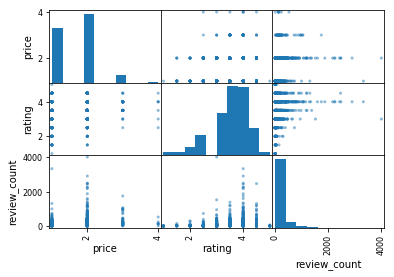

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

df.price = df.price.fillna(value=0)
price_dict = {"$": 1, "$$":2, "$$$": 3, "$$$$":4}
df.price = df.price.map(price_dict)

pd.plotting.scatter_matrix(df[['price', 'rating', 'review_count']])

## Mapping

Look at the initial Yelp example and try and make a map using Folium of the restaurants you retrieved. Be sure to also add popups to the markers giving some basic information such as name, rating and price.

In [7]:
import folium

lat_long = df['coordinates'].iloc[0]
lat = lat_long['latitude']
long = lat_long['longitude']
yelp_map = folium.Map([lat, long])

for row in df.index:
    try:
        lat_long = df['coordinates'][row]
        lat = lat_long['latitude']
        long = lat_long['longitude']
        name = df['name'][row]
        rating = df['rating'][row]
        price = df['price'][row]
        details = "{}\nPrice: {} Rating:{}".format(name,str(price),str(rating))
        popup = folium.Popup(details, parse_html=True)
        marker = folium.Marker([lat, long], popup=popup)
        marker.add_to(yelp_map)
    except:
        print('Hit error on row: {}'.format(row))
yelp_map

## Summary

Nice work! In this lab, you've made multiple API calls to Yelp in order to paginate through a results set, performing some basic exploratory analysis and then creating a nice interactive map to display the results using Folium! Well done!